# Test annotated data

In [1]:
import json
annotated_data = json.load(open('../data/val.json'))

In [2]:
print(json.dumps(annotated_data[:10], ))

[{"video_id": "cfBtVPEwqIo", "video_start_time": 5, "video_end_time": 15, "caption": "In a gym with someone spotting him, a man is lifting weights performing squats in a squat rack.", "masked_caption": "In a gym with someone spotting him, a man is lifting _____ performing squats in a squat rack.", "label": "weights", "additional_answers": [["a weight", "some weights", "a squat bar"], ["weight", "a bar"], ["weights", "a heavy load"], ["weights", "a lot of weight"], ["weights", "a barbell", "a weight"], ["weights", "405 lb"]]}, {"video_id": "P7CgvqGhidw", "video_start_time": 73, "video_end_time": 83, "caption": "A couple of people on stage playing music while in front of other people.", "masked_caption": "A couple of people on stage playing music while in _____ of other people.", "label": "front", "additional_answers": [["close proximity", "close comfort"], ["front", "a room full"], ["front", "view"], ["entretaining", "talking"], ["front", "the way"], ["concert", "room"]]}, {"video_id": 

## Noun distribution
Let's look at the top-K nouns for (1) ground-truth data and (2) labeled data.

In [3]:
import pandas as pd
ground_truth_labels = list(map(lambda x: x['label'].lower(), annotated_data))
ground_truth_label_counts = pd.Series(ground_truth_labels).value_counts()
display(ground_truth_label_counts.head(20))

a man          46
a person       27
it             23
a woman        21
people         13
them           12
front          10
a group        10
he             10
someone        10
a boy           8
a young man     8
a piece         7
a child         6
a girl          6
the water       5
two boys        5
they            5
a lady          4
a bowl          4
dtype: int64

In [4]:
from functools import reduce
annotation_labels = []
for annotated_data_i in annotated_data:
    for annotations_j in annotated_data_i['additional_answers']:
        clean_annotations_j = list(map(lambda x: x.lower(), annotations_j))
        annotation_labels.extend(clean_annotations_j)
annotation_label_counts = pd.Series(annotation_labels).value_counts()
display(annotation_label_counts.head(20))

a person    392
a man       381
a woman     181
a guy       164
people      154
someone     133
a girl      115
a boy       111
a group     108
a child     104
a kid       103
a lady       93
man          70
kids         68
it           68
music        61
a baby       59
the man      57
he           54
boys         50
dtype: int64

### Nouns with low/high agreement
Which nouns have lower or higher agreement?

We'll measure agreement with exact overlap to start, and then partial overlap if we need more data.

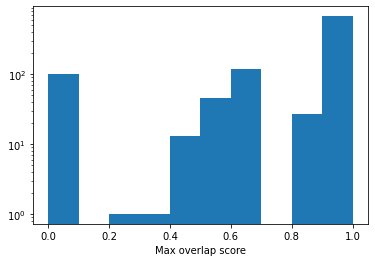

In [14]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.metrics import normalize_answer, tokenize_answer_to_compute_metrics, compute_token_level_f1_many
def compute_overlap_score(label, annotations):
    label_tokens = tokenize_answer_to_compute_metrics(normalize_answer(label))
    annotation_tokens = list(map(lambda x: list(map(lambda y: tokenize_answer_to_compute_metrics(normalize_answer(y)), x)), annotations))
    # flatten token lists
    annotation_tokens = [y for x in annotation_tokens for y in x]
    overlap_score = compute_token_level_f1_many(label_tokens, annotation_tokens)
    return overlap_score
valid_annotated_data = list(filter(lambda x: len(x['additional_answers']) > 0, annotated_data))
overlap_scores = list(map(lambda x: compute_overlap_score(x['label'], x['additional_answers']), valid_annotated_data))
# # show distribution first
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(overlap_scores)
plt.xlabel("Max overlap score")
plt.yscale('log')
plt.show()

Most labels have relatively high match scores, which is to be expected given the (short) nature of the annotations.

In [13]:
## compute average overlap per NP
valid_annotated_data_labels = list(map(lambda x: x['label'], valid_annotated_data))
label_annotation_overlap = pd.DataFrame(list(zip(valid_annotated_data_labels, overlap_scores)), columns=['label', 'overlap_score'])
label_annotation_overlap_aggregate = label_annotation_overlap.groupby('label').apply(lambda x: x.loc[:, 'overlap_score'].mean())
label_annotation_overlap_aggregate.sort_values(inplace=True, ascending=False)
print('ground-truth labels with highest annotation overlap')
display(label_annotation_overlap_aggregate.head(20))
label_annotation_overlap_aggregate.sort_values(inplace=True, ascending=True)
print('ground-truth labels with lowest annotation overlap')
display(label_annotation_overlap_aggregate.head(20))

ground-truth labels with highest annotation overlap


label
A  young woman       1.0
camels               1.0
ballons              1.0
a black marker       1.0
baskets              1.0
a birthday candle    1.0
a bikini             1.0
a big belly          1.0
a bicycle chain      1.0
boys                 1.0
bread dough          1.0
a bench              1.0
a belly dance        1.0
camera               1.0
a crocodile          1.0
a bed                1.0
cards                1.0
circles              1.0
classical music      1.0
clay                 1.0
dtype: float64

ground-truth labels with lowest annotation overlap


label
a small robotic vehicle     0.0
components                  0.0
a band                      0.0
a icy clift                 0.0
wind                        0.0
a beat making machine       0.0
voices                      0.0
the ledge                   0.0
camo paint                  0.0
a load                      0.0
building block formation    0.0
a lot                       0.0
flag                        0.0
use                         0.0
twos                        0.0
buns                        0.0
a blow up toy               0.0
bangers                     0.0
themselves                  0.0
a press                     0.0
dtype: float64

The words with higher agreement tend to be simple and concrete nouns (`young woman`, `crocodile`).

The words with lower agreement tend to be highly specific (`a beat making machine`, `building block formation`) or vague (`use`, `themselves`).

## Tokens per NP
How many tokens on average does each noun phrase contain?

We'll look at this for both ground-truth and annotations.

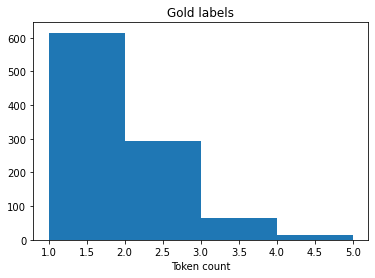

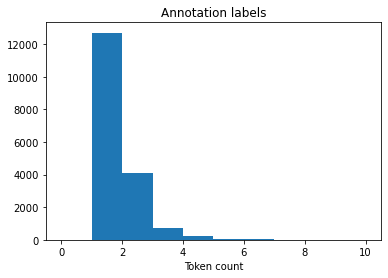

gold label NPs have 1.469 +/- 0.686 tokens
annotation NPs have 1.368 +/- 0.686 tokens


In [18]:
import numpy as np
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.metrics import normalize_answer, tokenize_answer_to_compute_metrics
label_token_counts = list(map(lambda x: len(tokenize_answer_to_compute_metrics(normalize_answer(x))), valid_annotated_data_labels))
flat_annotation_labels = [z for x in valid_annotated_data for y in x['additional_answers'] for z in y]
annotation_label_token_counts = [len(tokenize_answer_to_compute_metrics(normalize_answer(x))) for x in flat_annotation_labels]
## show both distributions
plt.hist(label_token_counts, bins=len(set(label_token_counts))-1)
plt.xlabel('Token count')
plt.title('Gold labels')
plt.show()
plt.hist(annotation_label_token_counts, bins=len(set(annotation_label_token_counts))-1)
plt.xlabel('Token count')
plt.title('Annotation labels')
plt.show()
print('gold label NPs have %.3f +/- %.3f tokens'%(np.mean(label_token_counts), np.std(label_token_counts)))
print('annotation NPs have %.3f +/- %.3f tokens'%(np.mean(annotation_label_token_counts), np.std(annotation_label_token_counts)))

The gold labels tend to be slightly longer, but the annotations have a longer tail (>= 4 tokens).

What are the longest/shortest labels in each set?

In [20]:
label_token_count_data = pd.Series(label_token_counts, index=list(map(lambda x: normalize_answer(x.lower()), valid_annotated_data_labels))).sort_values(inplace=False, ascending=False)
flat_annotation_label_token_count_data = pd.Series(annotation_label_token_counts, index=list(map(lambda x: normalize_answer(x.lower()), flat_annotation_labels))).sort_values(inplace=False, ascending=False)
label_token_count_data = label_token_count_data[~label_token_count_data.index.duplicated()]
flat_annotation_label_token_count_data = flat_annotation_label_token_count_data[~flat_annotation_label_token_count_data.index.duplicated()]
print('longest gold label NPs')
display(label_token_count_data.head(20))
print('longest annotation NPs')
display(flat_annotation_label_token_count_data.head(20))

longest gold label NPs


innocent cute little baby boy    5
black and white knitting kit     5
very well built woman            4
complex stretching yoga pose     4
her very colorful leggings       4
ornately costumed dance squad    4
about nine game pieces           4
strung out teenage girls         4
his rock climbing equipment      4
large multiple dig site          4
his toy train set                4
human ping pong ball             4
basic photo copy machine         4
different gear shifts            3
automatic teller machine         3
two little boys                  3
beat making machine              3
her overstressed tanktop         3
small motorized carts            3
two young boys                   3
dtype: int64

longest annotation NPs


2 teams one in yellow jerseys and one white jerseys    10
poor animal who needs its wool to stay warm             9
2 people total and 1 in full view                       8
cowboy wearing blue jeans and blue jean jacket          8
male wearing shoes and black pants with stripes         8
boy in black and boy in blue tshirt                     8
2 young kids with shorts and no shirts                  8
girl in tshirt and bathing suit bottom                  7
shirtless man with black bottom bathing suit            7
2 males wearing blue shirt and shorts                   7
kid in black shirt and black pants                      7
while sitting and using fork to eat                     7
man in white shirt and black pants                      7
street in front of house driveway                       6
2 teams wearing jerseys and helmets                     6
front of green curtain and front                        6
man with small amounts of hair                          6
numerous track

The longest NPs for the gold labels tend to have multiple adjectives (`innocent cute little baby boy`) and complex nouns (`automatic teller machine`).

The longest NPs for the annotation labels tend to have coordination (`2 teams one in yellow jerseys and one white jerseys`) and long, unnecessary subclauses (`poor animal who needs it's wool to stay warm`).

### Unique NPs per question
How many unique NPs does each question get?

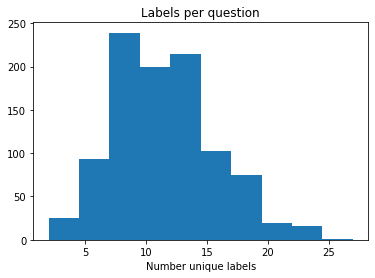

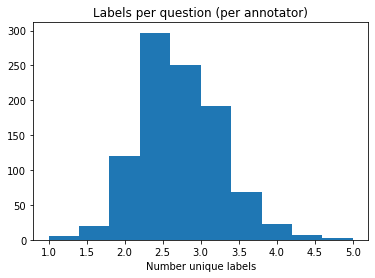

questions have an average of 11.292 +/- 4.126 unique labels
annotators have an average of 2.704 +/- 0.534 unique labels


In [22]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.metrics import normalize_answer
def get_num_unique_labels_per_annotator(data):
    ## TODO: only include first label from each annotator? some annotators may have included extra words just for bonus
    data_annotation_label_sets = [set([normalize_answer(y.lower()) for y in x]) for x in data['additional_answers']]
    num_unique_data_annotation_labels = list(map(lambda x: len(x), data_annotation_label_sets))
    mean_unique_data_annotation_labels = np.mean(num_unique_data_annotation_labels)
    return mean_unique_data_annotation_labels
unique_labels_per_question = list(map(lambda x: list(sorted(set([normalize_answer(z.lower()) for y in x['additional_answers'] for z in y]))), valid_annotated_data))
num_unique_labels_per_question = list(map(lambda x: len(x), unique_labels_per_question))
num_unique_labels_per_question_per_annotator = list(map(lambda x: get_num_unique_labels_per_annotator(x), valid_annotated_data))
plt.hist(num_unique_labels_per_question)
plt.xlabel('Number unique labels')
plt.title('Labels per question')
plt.show()
plt.hist(num_unique_labels_per_question_per_annotator)
plt.xlabel('Number unique labels')
plt.title('Labels per question (per annotator)')
plt.show()
print('questions have an average of %.3f +/- %.3f unique labels'%(np.mean(num_unique_labels_per_question), np.std(num_unique_labels_per_question)))
print('annotators have an average of %.3f +/- %.3f unique labels'%(np.mean(num_unique_labels_per_question_per_annotator), np.std(num_unique_labels_per_question_per_annotator)))

Most questions have around 12 unique labels total and 3 unique labels per annotator.

Which questions have the most unique labels per annotator?

In [24]:
pd.set_option('display.max_colwidth', 200)
question_prompts = list(map(lambda x: x['masked_caption'], valid_annotated_data))

unique_labels_per_question_per_annotator_data = pd.DataFrame([
    question_prompts,
    num_unique_labels_per_question_per_annotator,
    unique_labels_per_question,
], index=['prompt', 'unique_label_count', 'unique_labels']).transpose()
unique_labels_per_question_per_annotator_data.sort_values('unique_label_count', inplace=True, ascending=False)
print('questions with highest number unique labels per annotator')
display(unique_labels_per_question_per_annotator_data.head(10))
print('questions with lowest number unique labels per annotator')
display(unique_labels_per_question_per_annotator_data.tail(10))

questions with highest number unique labels per annotator


,prompt,unique_label_count,unique_labels
278,_____ lifts a heavy weight from the ground up.,5,"[athlete, body builder, bodybuilder, female, female athlete, female body builder, female bodybuilder, gal, girl, lady, small lady, small woman, tiny lady, weight lifter, woman]"
905,A group of drivers race cars on _____ in front of onlookers.,4.8,"[circuit, clay, course, dirt, dirt path, dirt track, dry sand, field, ground, mud, race grounds, racetrack, raceway, sand, speedway, stretch, track]"
260,A man is walking by _____ that is completely full then comes back and smashes the computer monitor sitting on top with a baseball bat.,4.71429,"[alley, bin, black bin, black bin with garbage, black garbage bin, black rubbish bin, black trash can, black trashcan, dumpster, garbage bin, garbage can, garbage receptacle, grey garbage can, pla..."
427,A group of _____ in pink tutus dancing in a circle on stage.,4.42857,"[arminarm girls, balet students, ballerinas, children, dancers, girls, kids, little girls, little kids, students, toddlers, young ballerinas, young dancers, young girls]"
45,A woman works with _____ at a spinning potter's wheel.,4.42857,"[bowl, boys, boys and girls, class, clay, ease, focus, girls, her children, her class, her family, her hands, her kids, her students, kids, lady, mud, piece of pottery, potter, pottery, skill, stu..."
831,_____ uses several smaller containers to efficiently pack a suitcase while music plays.,4.33333,"[chick, female, girl, lady, lass, person, someone, traveler, woman, young lady]"
835,_____ was picking berries from a bush outside on a sunny day.,4.33333,"[adult and child, duo, family, folks, girl, mother and daughter, people, person, woman, woman and girl, young lady and old lady]"
936,_____ kicks soccer balls into a net while on a grass field.,4.33333,"[adolescent, athlete, boy, child, guy, human, kid, male, my daughters friend, our neighbor, person, player, players, soccer player, someone, son, team member, teams captain, young boy, youth]"
576,_____ plays an instrument while wearing a pink shirt.,4.2,"[artist, bald man, entertainer, guy, individual, man, musician, old man, older man, performer, person, saxophone player, saxophonist, singer, someone]"
749,A man standing in front of a microphone playing some kind of _____.,4.2,"[flute, harmonicalike instrument, instrument, music, musical instrument, noise, pan flute, pan flute music, panflute, pipe, song, tool, unknown instrument, wood instrument, wooden instrument, wood..."


questions with lowest number unique labels per annotator


,prompt,unique_label_count,unique_labels
645,A man demonstrates how to install _____.,1.66667,"[bicycle chain, bike chain, chain, cycle chain, master link, new bike chain, new chain links, piece of equipement]"
863,The man in _____ checks and trims the toenails of a small animal.,1.625,"[black pants, black sweater, chair, clip, knit shirt, sweater, vets office, video, warm sweater]"
613,Two person one standing on _____ and the other doing a cock wheel.,1.6,"[circle, floor, groung, his head, their head, top of his head]"
468,A man juggles balls one-handed and then two-handed and tosses them to a person off-_____.,1.5,"[balance, camera, frame, shot]"
306,A toddler boy is feeding _____ spaghetti at the dinner table.,1.5,"[forkfuls of, himself, his belly, his mouth, while sitting and using fork to eat]"
720,A young boy who seems to be timing _____ how fast he can eat a snack.,1.33333,"[challenge of, himself, his self, recording of, to calculate, to see]"
747,"A man, outdoors at a gas station, is demonstrating step-by-_____, how to pump gas.",1.33333,"[step, way]"
214,"Two teams play football, and the team in _____ completes a pass.",1.33333,"[left, offense, red jerseys, red shirts]"
705,Packages of paper are being wrapped in paper plastic and stacked on _____ of each other.,1.25,"[device next, machine, top]"
847,A person is showing how _____ open a beer with a screw driver indoors.,1,"[he, people, to screw open, you]"


Questions with higher number of unique labels seem to inspire creative answers (`a group of ____ in pink tutus` => different paraphrases for `child`) and address multiple possible aspects of an event due to ambiguity (`a woman works with ____` => "with" applies to other `AGENT` nouns and `INSTRUMENT` nouns).

Questions with lower number of unique labels seem to have very specific scenarios without room for paraphrasing or ambiguity (`to a person off-____` => the blank can only be "camera").

### Assessing visual cues
Some nouns and adjectives have more obvious visual cues than others, ex. "green" has clear visual component whereas "kind" is more subjective.

Let's look for these visual cues in the labels and annotations using some word lists:
- color
- size
- number

In [29]:
## TODO: expand word sets using word embeddings (nearest neighbors + filtering)
color_words = {
    'red', 'blue', 'green', 'yellow', 'purple', 'orange', 'black', 'white', 'gray', 'grey',
    'colorful', 'painted',
}
size_words = {
    'large', 'huge', 'giant', 'small', 'little', 'tiny',
}
number_words = {
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
    'several', 'few', 'many',
}
visual_word_sets = [
    color_words, size_words, number_words,
]
visual_word_set_names = [
    'color', 'size', 'number',
]

In [40]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.metrics import normalize_answer, tokenize_answer_to_compute_metrics
def normalize_tokenize(label):
    label_tokens = tokenize_answer_to_compute_metrics(normalize_answer(label))
    return label_tokens
## tokenize everything
label_tokens = list(map(lambda x: normalize_tokenize(x['label']), annotated_data))
annotation_label_tokens = [[normalize_tokenize(z) for z in y] for x in valid_annotated_data for y in x['additional_answers']]

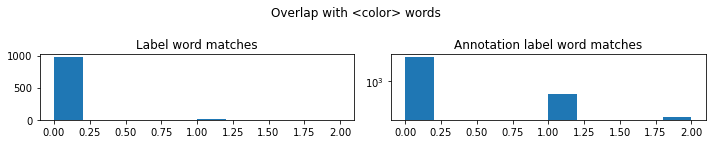

proportion of word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.984802                   0.986248
1           1              0.014184                   0.012910
2           2              0.001013                   0.000842


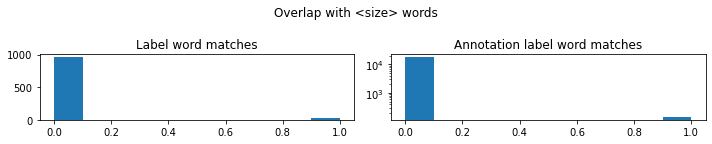

proportion of word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.969605                   0.991636
1           1              0.030395                   0.008364


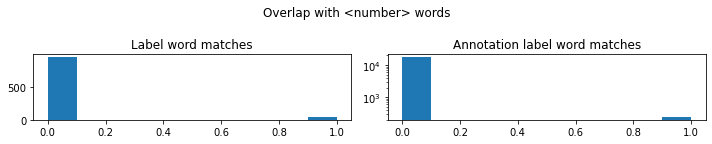

proportion of word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.963526                   0.986191
1           1              0.036474                   0.013809


In [48]:
## get counts, plot distribution of visual words
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
for visual_word_set, visual_word_set_name in zip(visual_word_sets, visual_word_set_names):
    label_word_matches = list(map(lambda x: set(x) & visual_word_set, label_tokens))
    annotation_label_word_matches = [set(y) & visual_word_set for x in annotation_label_tokens for y in x]
    num_label_word_matches = list(map(lambda x: len(x), label_word_matches))
    num_annotation_label_word_matches = list(map(lambda x: len(x), annotation_label_word_matches))
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 2))
    axs[0].hist(num_label_word_matches)
    axs[1].hist(num_annotation_label_word_matches)
    axs[0].set_title('Label word matches')
    axs[1].set_title('Annotation label word matches')
    plt.suptitle(f'Overlap with <{visual_word_set_name}> words')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    # compute proportion of visual words per question
    pct_label_word_matches = pd.Series(num_label_word_matches).value_counts() / len(num_label_word_matches)
    pct_annotation_label_word_matches = pd.Series(num_annotation_label_word_matches).value_counts() / len(num_annotation_label_word_matches)
    pct_word_matches = pd.concat([pct_label_word_matches, pct_annotation_label_word_matches], axis=1).reset_index()
    pct_word_matches.columns = ['word_count', 'label_word_match_pct', 'annotation_word_match_pct']
#     pct_word_matches.columns = ['label_match_pct', 'annotation_label_match_pct']
    print(f'proportion of <{visual_word_set_name}> word matches for labels:\n{pct_word_matches}')

Overall, the annotations tend to have about the rate of color words as the labels, but the annotations also have fewer size and number words than the labels.

What are some example questions where the label contains a visual word but the annotations do not?

In [58]:
valid_annotation_label_tokens = [[normalize_tokenize(z) for y in x['additional_answers'] for z in y] for x in valid_annotated_data]
# flatten tokens
valid_annotation_label_tokens = [[z for y in x for z in y] for x in valid_annotation_label_tokens]
print(valid_annotated_data[0])
print(valid_annotation_label_tokens[0])

{'video_id': 'cfBtVPEwqIo', 'video_start_time': 5, 'video_end_time': 15, 'caption': 'In a gym with someone spotting him, a man is lifting weights performing squats in a squat rack.', 'masked_caption': 'In a gym with someone spotting him, a man is lifting _____ performing squats in a squat rack.', 'label': 'weights', 'additional_answers': [['a weight', 'some weights', 'a squat bar'], ['weight', 'a bar'], ['weights', 'a heavy load'], ['weights', 'a lot of weight'], ['weights', 'a barbell', 'a weight'], ['weights', '405 lb']]}
['weight', 'some', 'weights', 'squat', 'bar', 'weight', 'bar', 'weights', 'heavy', 'load', 'weights', 'lot', 'of', 'weight', 'weights', 'barbell', 'weight', 'weights', '405', 'lb']


In [62]:
## get aligned/valid data
valid_label_tokens = list(map(lambda x: normalize_tokenize(x['label']), valid_annotated_data))
valid_annotation_label_tokens = [[normalize_tokenize(z) for y in x['additional_answers'] for z in y] for x in valid_annotated_data]
# flatten tokens
valid_annotation_label_tokens = [[z for y in x for z in y] for x in valid_annotation_label_tokens]
sample_size = 10
for visual_word_set, visual_word_set_name in zip(visual_word_sets, visual_word_set_names):
    print(f'*~*~*~* testing word set {visual_word_set_name} *~*~*~*')
    label_word_matches = list(map(lambda x: set(x) & visual_word_set, valid_label_tokens))
    annotation_label_word_matches = list(map(lambda x: set(x) & visual_word_set, valid_annotation_label_tokens))
    sample_ctr = 0
    for data_i, label_word_matches_i, annotation_label_word_matches_i in zip(valid_annotated_data, label_word_matches, annotation_label_word_matches):
        if(len(label_word_matches_i) > 0 and len(annotation_label_word_matches_i) == 0):
            print(f'caption=<{data_i["caption"]}>')
            print(f'label=<{data_i["label"]}> has matches <{label_word_matches_i}>')
            print(f'annotations do not have matches: <{data_i["additional_answers"]}>')
            print('---------')
            sample_ctr += 1
            if(sample_ctr >= sample_size):
                break

*~*~*~* testing word set color *~*~*~*
caption=<A red hot piece of bent steel is being formed with a metal sledge hammer on the end of a  steel table.>
label=<A red hot piece> has matches <{'red'}>
annotations do not have matches: <[['A horseshoe', 'A shoe', 'An arch', 'A U-shape', 'An object'], ['A piece', 'A horseshoe'], ['a rod', 'a segment'], ['hot iron'], ['A large are', 'A big area'], ['A piece', 'A long piece', 'A hot piece'], ['A piece', 'A rod', 'A chunk'], ['A piece', 'A part'], ['A piece', 'A heated piece']]>
---------
caption=<A gir lis trying to stitching up the black and white knitting kit with a knitting needle.>
label=<the black and white knitting kit> has matches <{'white', 'black'}>
annotations do not have matches: <[['a scarf', 'a line on a scarf'], ['a piece of clothing', 'some cloth'], ['a scarf', 'her scarf'], ['crochet', 'string', 'thread'], ['a scarf', 'some fabric']]>
---------
caption=<A man is using a strainer to strain a black grainy substance, while music i

- Color: the mismatches are due to highly specific captions, no necessary information being conveyed by the color.
- Size: the mismatches are due to annotators focusing more on paraphrases for the noun (`class`, `crowd`, `mass`) and different aspects of the scene (`the rain`, `the city`).
- Number: the mismatches are due to annotators focusing more on paraphrases for the noun (`people`, `believers`, `patrons`) and different aspects of the scene (`plates`, `dishes`, `glasses`).